<a href="https://colab.research.google.com/github/learning-boat/snappod-synopses/blob/main/Podcast_Summarizer_using_OpenAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install modal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.1/285.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 8.1 MB/s eta 0:00:00
  Created wheel for grpclib: filename=grpclib-0.4.3-py3-none-any.whl size=77058 sha256=f06cac91a5f0cff3b90f58b6e795be7085a88d7dd07580b794f82ffdebfdc874
  Stored in directory: /root/.cache/pip/wheels/e0/49/4d/31aa7f3f43e9833b8e79204457b404ad4434fc2278a32fa9f1
Successfully built grpclib
  Attempting unins

In [2]:
!modal token new --source corise > authenticationURL.txt

In [3]:
import getpass
import subprocess

def set_modal_token():
  token_id = getpass.getpass('Please enter your Modal token ID in the cell: ')
  token_secret = getpass.getpass('Please enter your Modal token secret in the cell:  ')

  # Using subprocess to execute the command
  subprocess.run(f"!modal token set --token-id (token_id) --token-secret (token_secret)", shell=True)

In [4]:
set_modal_token()

Please enter your Modal token ID in the cell: ··········
Please enter your Modal token secret in the cell:  ··········


## Create a cloud information extraction function

In [8]:
!mkdir podcast

In [9]:
%%writefile /content/podcast/podcast_backend.py
import modal

def download_whisper():
  # Load the Whisper model
  import os
  import whisper
  print ("Download the Whisper model")

  # Perform download only once and save to Container storage
  whisper._download(whisper._MODELS["medium"], '/content/podcast/', False)


stub = modal.Stub("corise-podcast-project")
corise_image = modal.Image.debian_slim().pip_install("feedparser",
                                                     "https://github.com/openai/whisper/archive/9f70a352f9f8630ab3aa0d06af5cb9532bd8c21d.tar.gz",
                                                     "requests",
                                                     "ffmpeg",
                                                     "openai",
                                                     "tiktoken",
                                                     "wikipedia",
                                                     "ffmpeg-python").apt_install("ffmpeg").run_function(download_whisper)

@stub.function(image=corise_image, gpu="any", timeout=600)
def get_transcribe_podcast(rss_url, local_path):
  print ("Starting Podcast Transcription Function")
  print ("Feed URL: ", rss_url)
  print ("Local Path:", local_path)

  # Read from the RSS Feed URL
  import feedparser

  intelligence_feed = feedparser.parse(rss_url)

  podcast_title = intelligence_feed['feed']['title']
  episode_title = intelligence_feed.entries[0]['title']
  episode_image = intelligence_feed['feed']['image'].href

  for item in intelligence_feed.entries[0].links:
    if (item['type'] == 'audio/mpeg'):
      episode_url = item.href

  episode_name = "podcast_episode.mp3"
  print ("RSS URL read and episode URL: ", episode_url)

  # Download the podcast episode by parsing the RSS feed
  from pathlib import Path

  p = Path(local_path)
  p.mkdir(exist_ok=True)

  print ("Downloading the podcast episode")

  import requests

  with requests.get(episode_url, stream=True) as r:
    r.raise_for_status()
    episode_path = p.joinpath(episode_name)
    with open(episode_path, 'wb') as f:
      for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)

  print ("Podcast Episode downloaded")

  # Load the Whisper model
  import os
  import whisper

  # Load model from saved location
  print ("Load the Whisper model")
  model = whisper.load_model('medium', device='cuda', download_root='/content/podcast/')

  # Perform the transcription
  print ("Starting podcast transcription")
  result = model.transcribe(local_path + episode_name)

  # Return the transcribed text
  print ("Podcast transcription completed, returning results...")

  output = {}
  output['podcast_title'] = podcast_title
  output['episode_title'] = episode_title
  output['episode_image'] = episode_image
  output['episode_transcript'] = result['text']

  return output

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_summary(podcast_transcript):
  import openai

  instructPrompt = """
  You are an expert in giving concise and meaningful summary to any given topic. You need to summarize the podcast episode which is being provided to you for a varity of large number of auidance.
  Make the summary intersting, meanhingful and precise.
  The podcast is provided below.
  """
  request = instructPrompt + podcast_transcript
  chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
  podcastSummary = chatOutput.choices[0].message.content
  return podcastSummary

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"))
def get_podcast_highlights(podcast_transcript):
  import openai
  instructPrompt = """
  You are a stoic disciple. You are given a transcript of a stoic preaching, your job is to given a preaching transcript provide highlights of the transcript.
  Do not try and make up the highlight, they should be present as part of the transcript. Please provide the output in 5 lines with each line containing a highlight.
  Also, add a section after highlights named as "Topics to further explore:" and give 3-5 words related to or extension of what was mentioned in the podcast
  The podcast is provided below.
  """
  request = instructPrompt + podcast_transcript

  chatOutput = openai.ChatCompletion.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )
  podcastHighlights = chatOutput.choices[0].message.content
  return podcastHighlights

@stub.function(image=corise_image, secret=modal.Secret.from_name("my-openai-secret"), timeout=1200)
def process_podcast(url, path):
  output = {}

  podcast_details = get_transcribe_podcast.call(url, path)
  podcast_summary = get_podcast_summary.call(podcast_details['episode_transcript'])
  podcast_highlights = get_podcast_highlights.call(podcast_details['episode_transcript'])

  output['podcast_details'] = podcast_details
  output['podcast_summary'] = podcast_summary
  output['podcast_highlights'] = podcast_highlights

  return output

@stub.local_entrypoint()
def test_method(url, path):
  output = {}

  podcast_details = get_transcribe_podcast.call(url, path)

  print ("Podcast Summary: ", get_podcast_summary.call(podcast_details['episode_transcript']))
  print ("Podcast Highlights: ", get_podcast_highlights.call(podcast_details['episode_transcript']))

Writing /content/podcast/podcast_backend.py


In [10]:
!modal run /content/podcast/podcast_backend.py --url https://rss.art19.com/the-daily-stoic --path /content/podcast/

✓ Initialized. View app at https://modal.com/apps/ap-3A5b14j53yvKPPzRpttmfI
⠋ Initializing...
⠦ Creating objects...
├── ⠋ Creating get_transcribe_podcast...
└── ⠋ Creating mount /content/podcast/podcast_backend.py: Uploaded 0/0 inspected
⠏ Creating objects...
├── ⠸ Creating get_transcribe_podcast...
⠹ Creating objects...
├── ⠦ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── ⠋ Creating download_whisper...
└── ⠋ Creating mount /content/podcast/podcast_backend.py: Uploaded 0/0 inspected
⠴ Creating objects...
├── ⠏ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── ⠸ Creating download_whisper...
⠇ Creating objects...
├── ⠹ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── 🔨 Created download_whisper.
⠹ Creating objects...
├── 🔨 Created get_transcribe_podcast.
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── 🔨 Created download_whisper.
├── 🔨 Creat

In [11]:
!modal deploy /content/podcast/podcast_backend.py

⠦ Creating objects...
├── ⠋ Creating get_transcribe_podcast...
└── ⠋ Creating mount /content/podcast/podcast_backend.py: Uploaded 0/0 inspected
⠏ Creating objects...
├── ⠸ Creating get_transcribe_podcast...
⠹ Creating objects...
├── ⠦ Creating get_transcribe_podcast...
⠴ Creating objects...
├── ⠏ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── ⠋ Creating download_whisper...
⠇ Creating objects...
├── ⠹ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── ⠸ Creating download_whisper...
⠹ Creating objects...
├── ⠴ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── 🔨 Created download_whisper.
⠴ Creating objects...
├── ⠇ Creating get_transcribe_podcast...
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── 🔨 Created download_whisper.
⠇ Creating objects...
├── 🔨 Created get_transcribe_podcast.
├── 🔨 Created mount /content/podcast/podcast_backend.py
├── 

In [12]:
# Trying to call the deployed function from another python session
import modal

f = modal.Function.lookup("corise-podcast-project", "process_podcast")
output = f.call('https://feeds.megaphone.fm/MOBI4141652289', '/content/podcast/')

<ipython-input-12-c3657c003bf6>:5: DeprecationError: 2018-08-16: `f.call(...)` is deprecated. It has been renamed to `f.remote(...)`
  output = f.call('https://feeds.megaphone.fm/MOBI4141652289', '/content/podcast/')


In [13]:
import json

with open("/content/podcast/podcast-1.json", "w") as outfile:
  json.dump(output, outfile)

In [14]:
output = f.call('https://feeds.npr.org/510355/podcast.xml', '/content/podcast/')

<ipython-input-14-e9858263b59f>:1: DeprecationError: 2018-08-16: `f.call(...)` is deprecated. It has been renamed to `f.remote(...)`
  output = f.call('https://feeds.npr.org/510355/podcast.xml', '/content/podcast/')


In [15]:
with open("/content/podcast/podcast-2.json", "w") as outfile:
  json.dump(output, outfile)

In [16]:
output = f.call('https://api.substack.com/feed/podcast/17202.rss', '/content/podcast/')

<ipython-input-16-a743aba70608>:1: DeprecationError: 2018-08-16: `f.call(...)` is deprecated. It has been renamed to `f.remote(...)`
  output = f.call('https://api.substack.com/feed/podcast/17202.rss', '/content/podcast/')


In [17]:
with open("/content/podcast/podcast-3.json", "w") as outfile:
  json.dump(output, outfile)

### Extension

There are multiple ways to speed-up the transcription process which is what takes the most amount of time. We provide some hints below on libraries and approaches if you want to extend your project -

- There is a super fast [implementation](https://github.com/sanchit-gandhi/whisper-jax) of Whisper using JAX which could be a drop-in replacement
- There is alternate approach of splitting up the audio into chunks by detecting silences and then parallelising it using multiple Modal GPU containers. They provide a very nice [example](https://github.com/modal-labs/modal-examples/tree/main/06_gpu_and_ml/openai_whisper/pod_transcriber) of how to achieve this

# Deploying the front-end application

In the final part of our AI product let's create a front-end for our podcast summarizer application. Since we want to create our product as a weekly newsletter, it's not necessary to have a front-end but this can help our users visualize what the newsletter looks like. It also gives them an opportunity to play around with their choice of RSS feeds.

Since we want to keep it simple we choose to go with a Streamlit application for our front-end. We can stick with Python as the programming language and also deploying it is easy and for free using the Streamlit Share.

## Deploy the Streamlit to the cloud

In [18]:
%%writefile /content/podcast/podcast_frontend.py
import streamlit as st
import modal
import json
import os

def main():
    st.title("SnapPod Synopses")

    available_podcast_info = create_dict_from_json_files('.')

    # Left section - Input fields
    st.sidebar.header("Podcast RSS Feeds")

    # Dropdown box
    st.sidebar.subheader("Available Podcasts Feeds")
    selected_podcast = st.sidebar.selectbox("Select Podcast", options=available_podcast_info.keys())

    if selected_podcast:

        podcast_info = available_podcast_info[selected_podcast]

        # Right section - Newsletter content
        st.header("Podcast Content")

        # Display the podcast title
        st.subheader("Episode Title")
        st.write(podcast_info['podcast_details']['episode_title'])

        # Display the podcast summary and the cover image in a side-by-side layout
        col1, col2 = st.columns([7, 3])

        with col1:
            # Display the podcast episode summary
            st.subheader("Podcast Episode Summary")
            st.write(podcast_info['podcast_summary'])

        with col2:
            st.image(podcast_info['podcast_details']['episode_image'], caption="Podcast Cover", width=300, use_column_width=True)

        # Display the five key moments
        st.subheader("Key Moments")
        key_moments = podcast_info['podcast_highlights']
        for moment in key_moments.split('\n'):
            st.markdown(
                f"<p style='margin-bottom: 5px;'>{moment}</p>", unsafe_allow_html=True)

    # User Input box
    st.sidebar.subheader("Add and Process New Podcast Feed")
    url = st.sidebar.text_input("Link to RSS Feed")

    process_button = st.sidebar.button("Process Podcast Feed")
    st.sidebar.markdown("**Note**: Podcast processing can take upto 5 mins, please be patient.")

    if process_button:

        # Call the function to process the URLs and retrieve podcast guest information
        podcast_info = process_podcast_info(url)

        # Right section - Newsletter content
        st.header("Newsletter Content")

        # Display the podcast title
        st.subheader("Episode Title")
        st.write(podcast_info['podcast_details']['episode_title'])

        # Display the podcast summary and the cover image in a side-by-side layout
        col1, col2 = st.columns([7, 3])

        with col1:
            # Display the podcast episode summary
            st.subheader("Podcast Episode Summary")
            st.write(podcast_info['podcast_summary'])

        with col2:
            st.image(podcast_info['podcast_details']['episode_image'], caption="Podcast Cover", width=300, use_column_width=True)

        # Display the five key moments
        st.subheader("Key Moments")
        key_moments = podcast_info['podcast_highlights']
        for moment in key_moments.split('\n'):
            st.markdown(
                f"<p style='margin-bottom: 5px;'>{moment}</p>", unsafe_allow_html=True)

def create_dict_from_json_files(folder_path):
    json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]
    data_dict = {}

    for file_name in json_files:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r') as file:
            podcast_info = json.load(file)
            podcast_name = podcast_info['podcast_details']['podcast_title']
            # Process the file data as needed
            data_dict[podcast_name] = podcast_info

    return data_dict

def process_podcast_info(url):
    f = modal.Function.lookup("corise-podcast-project", "process_podcast")
    output = f.call(url, '/content/podcast/')
    return output

if __name__ == '__main__':
    main()

Writing /content/podcast/podcast_frontend.py


In [23]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/podcast_frontend.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
%%writefile /content/podcast/requirements.txt
streamlit
modal

Overwriting /content/podcast/requirements.txt


In [25]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finally, we want to pre-populate the streamlit app with some pre-processed podcasts. You should have already done this in the previous section and saved the output JSON files. Please download them by executing the below cell. Please remember to change the names of the files based on what you chose in the previous section. We chose to go with the name - podcast-1, podcast-2 and so on.

In [26]:
from google.colab import files

# Download the file locally
files.download('/content/podcast/podcast-1.json')
files.download('/content/podcast/podcast-2.json')
files.download('/content/podcast/podcast-3.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Adding Modal secrets

Since we are going to call the cloud-deployed function directly from the app we also need to authenticate ourselves with Modal. For this we need to add the MODAL_TOKEN_ID and MODAL_TOKEN_SECRET to the secrets part of the Streamlit app.

To do this, please click on `Advanced settings` and then paste in your Token and Secrets as shown in the screenshot.

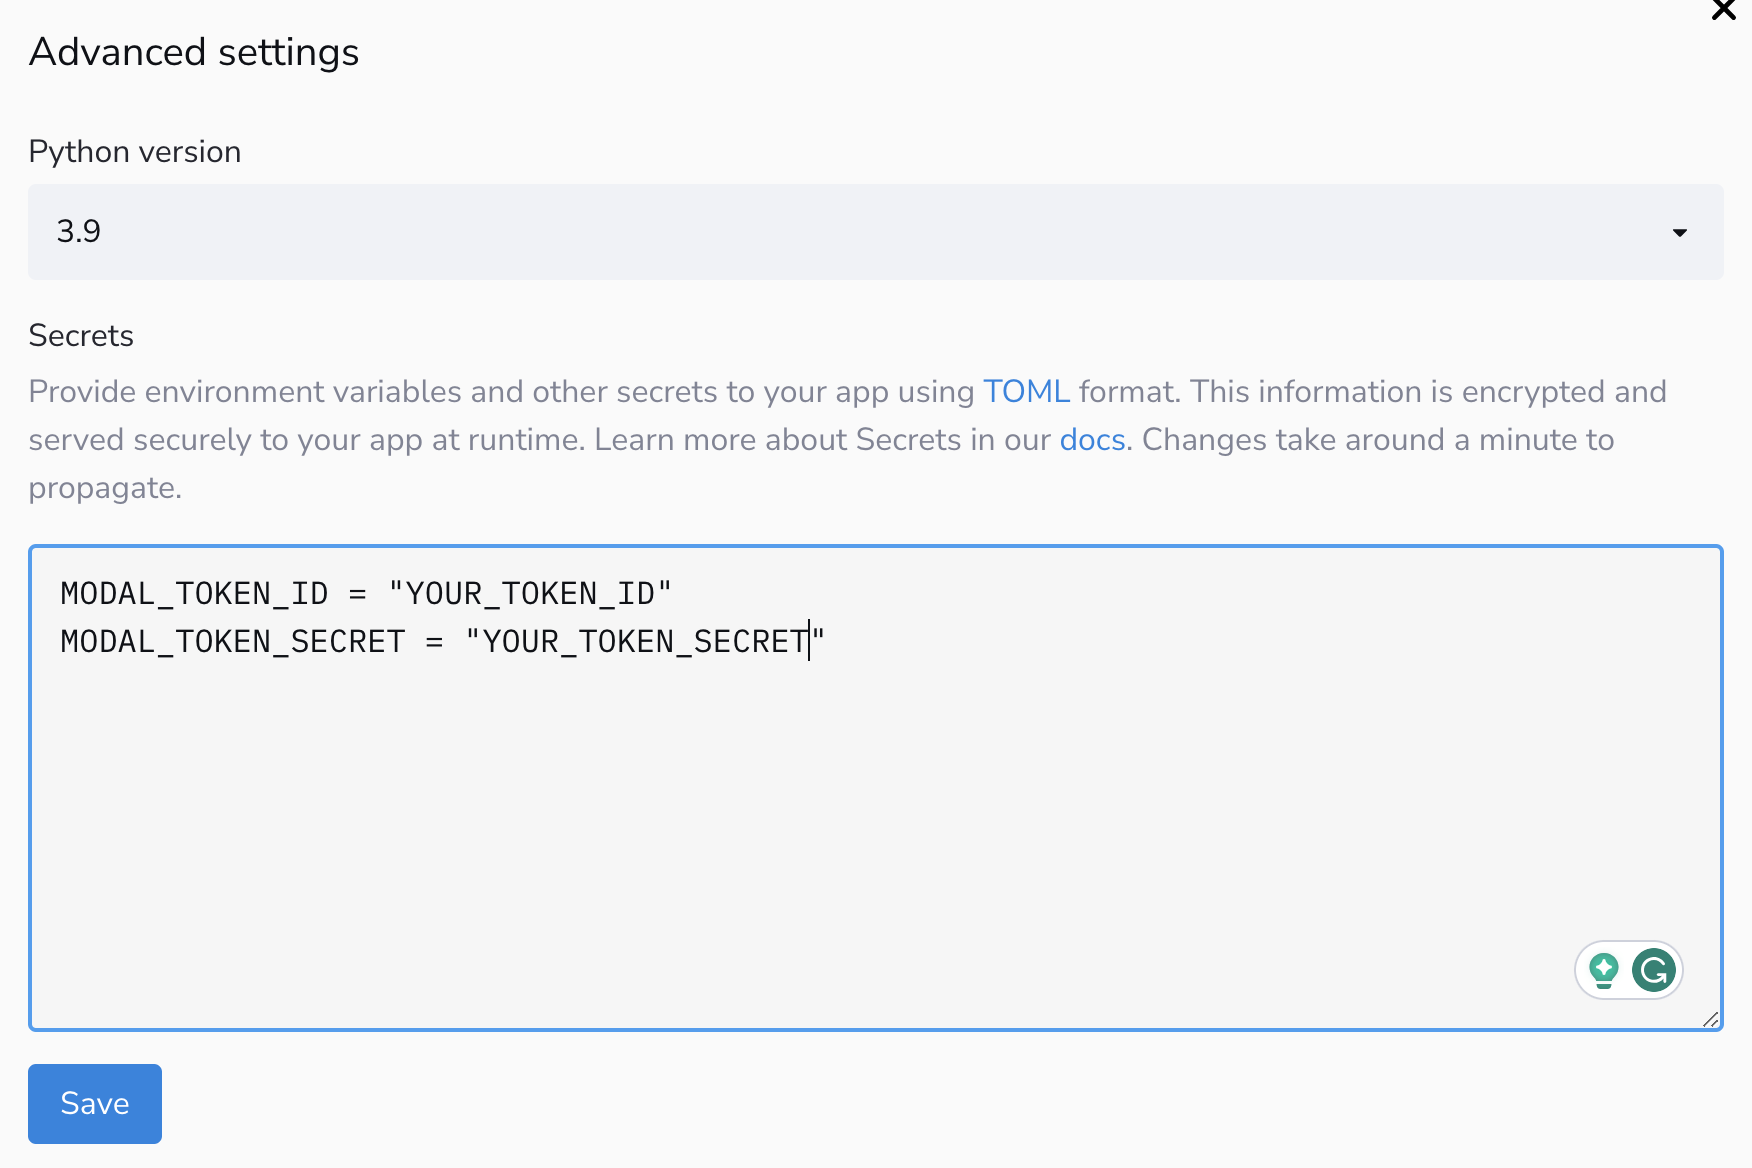